In [163]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AffinityPropagation, SpectralClustering, KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns   
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)


sns.set_theme(context='notebook', style='white', palette='bright')
SEED = 1234

In [164]:
df = pd.read_csv('../data/data_multidim/country_profile_variables.csv')

In [165]:
df.iloc[66,]

country                                                              Estonia
Region                                                        NorthernEurope
Surface area (km2)                                                     45227
Population in thousands (2017)                                          1310
Population density (per km2, 2017)                                      30.9
Sex ratio (m per 100 f, 2017)                                           88.2
GDP: Gross domestic product (million current US$)                      22460
GDP growth rate (annual %, const. 2005 prices)                           1.4
GDP per capita (current US$)                                         17112.0
Economy: Agriculture (% of GVA)                                          3.4
Economy: Industry (% of GVA)                                            27.4
Economy: Services and other activity (% of GVA)                         69.2
Employment: Agriculture (% of employed)                                  3.8

In [166]:
df.dtypes

country                                                        object
Region                                                         object
Surface area (km2)                                             object
Population in thousands (2017)                                  int64
Population density (per km2, 2017)                            float64
Sex ratio (m per 100 f, 2017)                                 float64
GDP: Gross domestic product (million current US$)               int64
GDP growth rate (annual %, const. 2005 prices)                 object
GDP per capita (current US$)                                  float64
Economy: Agriculture (% of GVA)                                object
Economy: Industry (% of GVA)                                  float64
Economy: Services and other activity (% of GVA)               float64
Employment: Agriculture (% of employed)                        object
Employment: Industry (% of employed)                           object
Employment: Services

In [167]:
df = df.applymap(lambda x: np.nan if x == -99 else x)

In [168]:
list_of_cols = ['Surface area (km2)', 'GDP growth rate (annual %, const. 2005 prices)', 'Economy: Agriculture (% of GVA)',
            'Employment: Agriculture (% of employed)', 'Employment: Industry (% of employed)', 'Employment: Services (% of employed)',
            'Unemployment (% of labour force)', 'International trade: Exports (million US$)', 'International trade: Imports (million US$)',
            'International trade: Balance (million US$)', 'Balance of payments, current account (million US$)',
            'Population growth rate (average annual %)', 'Urban population growth rate (average annual %)', 'Fertility rate, total (live births per woman)',
            'Refugees and others of concern to UNHCR (in thousands)', 'Infant mortality rate (per 1000 live births',
            'Health: Physicians (per 1000 pop.)', 'Education: Government expenditure (% of GDP)', 'Mobile-cellular subscriptions (per 100 inhabitants)',
            'Mobile-cellular subscriptions (per 100 inhabitants).1', 'Pop. using improved sanitation facilities (urban/rural, %)','Threatened species (number)']

In [169]:
def col_to_numeric(col):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    col = pd.to_numeric(col, errors='coerce')
    return col

In [170]:
df[list_of_cols] = df[list_of_cols].apply(col_to_numeric)

In [171]:
list_of_cols_paired = ['Labour force participation (female/male pop. %)', 'Life expectancy at birth (females/males, years)', 'Population age distribution (0-14 / 60+ years, %)',
                      'International migrant stock (000/% of total pop.)', 'Education: Primary gross enrol. ratio (f/m per 100 pop.)',
                      'Education: Secondary gross enrol. ratio (f/m per 100 pop.)', 'Education: Tertiary gross enrol. ratio (f/m per 100 pop.)',
                      'Forested area (% of land area)', 'Energy supply per capita (Gigajoules)', 'Pop. using improved drinking water (urban/rural, %)']

In [172]:
def seperate_paired_columns(col, df):
    col = col.apply(lambda x: np.nan if x == '-99' else x)
    tmp = col.str.split('/', 1, expand=True)
    tmp.columns = [col.name + "_option_A", col.name + "_option_B"]
    tmp = tmp.apply(pd.to_numeric, errors='coerce')
    df[tmp.columns.to_list()] = tmp

In [173]:
df[list_of_cols_paired] = df[list_of_cols_paired].apply(seperate_paired_columns, df=df)

In [174]:
df = df.drop(list_of_cols_paired, axis=1)

In [175]:
df1 = df[df.columns[df.isnull().sum()/len(df) <= 0.1]]
cor_matrix = df1.corr().abs()

In [176]:
upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k = 1).astype(bool))

In [177]:
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]

In [178]:
to_drop

['Food production index (2004-2006=100)',
 'International trade: Imports (million US$)',
 'Urban population growth rate (average annual %)',
 'Mobile-cellular subscriptions (per 100 inhabitants).1',
 'CO2 emission estimates (million tons/tons per capita)',
 'Life expectancy at birth (females/males, years)_option_A',
 'Life expectancy at birth (females/males, years)_option_B',
 'Population age distribution (0-14 / 60+ years, %)_option_A',
 'Population age distribution (0-14 / 60+ years, %)_option_B',
 'International migrant stock (000/% of total pop.)_option_A',
 'Forested area (% of land area)_option_A',
 'Forested area (% of land area)_option_B']

In [179]:
df2 = df1.drop(to_drop, axis=1)

In [180]:
country = df2['country']
region = df2['Region']
df2 = df2.drop(['country', 'Region'], axis=1)

In [181]:
df2 = df2.fillna(df2.mean())

In [182]:
df2

,Surface area (km2),Population in thousands (2017),"Population density (per km2, 2017)","Sex ratio (m per 100 f, 2017)",GDP: Gross domestic product (million current US$),"GDP growth rate (annual %, const. 2005 prices)",GDP per capita (current US$),Economy: Industry (% of GVA),Economy: Services and other activity (% of GVA),Agricultural production index (2004-2006=100),International trade: Balance (million US$),Population growth rate (average annual %),Urban population (% of total population),"Fertility rate, total (live births per woman)",Mobile-cellular subscriptions (per 100 inhabitants),Individuals using the Internet (per 100 inhabitants),Threatened species (number),"Energy production, primary (Petajoules)",International migrant stock (000/% of total pop.)_option_B
0,652864.0,35530,54.4,106.3,20270.000000,-2.400000,623.200000,23.300000,53.300000,125.000000,-2110.000000,3.200000,26.7,5.3,61.600000,42.0,2.1,5.000000,1.2
1,28748.0,2930,106.9,101.9,11541.000000,2.600000,3984.200000,26.000000,51.700000,134.000000,-2707.000000,-0.100000,57.4,1.7,106.400000,130.0,28.2,36.000000,2.0
2,2381741.0,41318,17.3,102.0,164779.000000,3.800000,4154.100000,37.300000,50.500000,160.000000,-17099.000000,2.000000,70.7,3.0,113.000000,135.0,0.8,55.000000,0.6
3,199.0,56,278.2,103.6,353896.341346,2.502899,15700.764423,27.565385,61.089423,112.000000,-683.861905,1.348198,87.2,2.6,107.360287,92.0,87.9,89.059361,41.8
4,468.0,77,163.8,102.3,2812.000000,0.800000,39896.400000,10.800000,88.600000,116.184834,-1255.000000,-1.600000,85.1,1.2,88.100000,13.0,34.0,119.000000,59.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,142.0,12,84.1,93.4,353896.341346,2.502899,15700.764423,27.565385,61.089423,115.000000,-51.000000,-2.100000,0.0,2.1,107.360287,89.0,41.6,26.000000,21.7
225,266000.0,553,2.1,110.1,353896.341346,2.502899,15700.764423,27.565385,61.089423,100.000000,-683.861905,1.800000,80.9,2.6,107.360287,49.0,2.7,89.059361,0.9
226,527968.0,28250,53.5,102.1,29688.000000,-28.100000,1106.400000,36.900000,48.400000,136.000000,-6291.000000,2.600000,34.6,4.4,68.000000,298.0,1.0,12.000000,1.3
227,752612.0,17094,23.0,98.5,21255.000000,2.900000,1311.100000,32.300000,59.500000,179.000000,-937.000000,3.000000,40.9,5.2,74.500000,88.0,65.6,26.000000,0.8


In [183]:
scaler = StandardScaler()
scaler.fit(df2)
X_transform = pd.DataFrame(scaler.transform(df2), columns=df2.columns)

In [184]:
%%time
tsne = TSNE(random_state=SEED, init='pca', n_jobs=-1)
X_tsne = tsne.fit_transform(X_transform)

Wall time: 2.09 s


<Figure size 576x576 with 0 Axes>

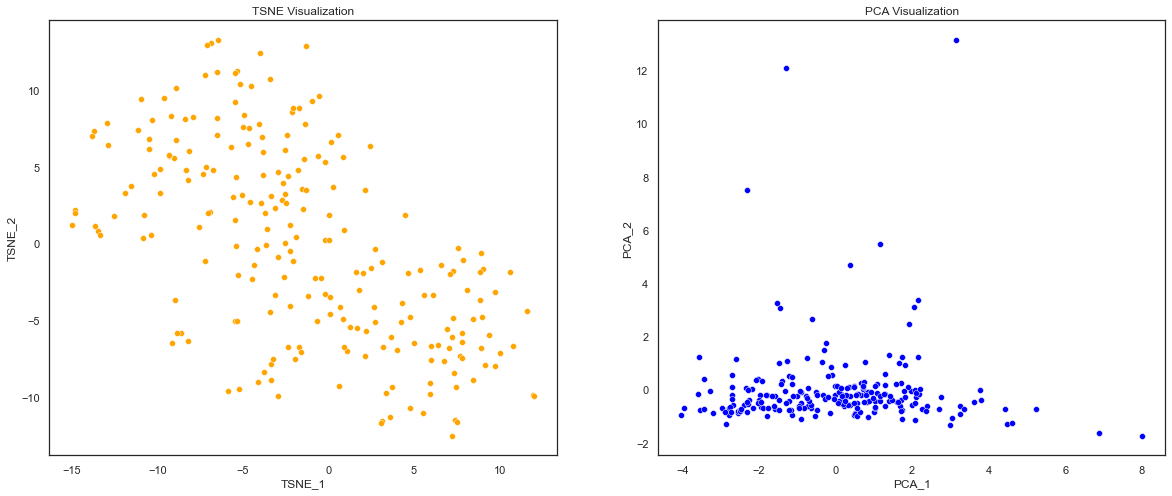

In [185]:
X_tsne = pd.DataFrame(X_tsne , columns=['TSNE_1', 'TSNE_2'])
plt.figure(figsize=(8, 8)) 
pca = PCA(n_components=2, random_state=SEED)
pca.fit(X_transform)
X_pca = pca.transform(X_transform)
X_pca = pd.DataFrame(X_pca, columns=['PCA_1', 'PCA_2'])
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8));
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', ax=axes[0], color='orange').set_title('TSNE Visualization');
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', ax=axes[1], color='blue').set_title('PCA Visualization');

In [186]:
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=SEED).fit(X_transform)
    inertia.append(np.sqrt(kmeans.inertia_))

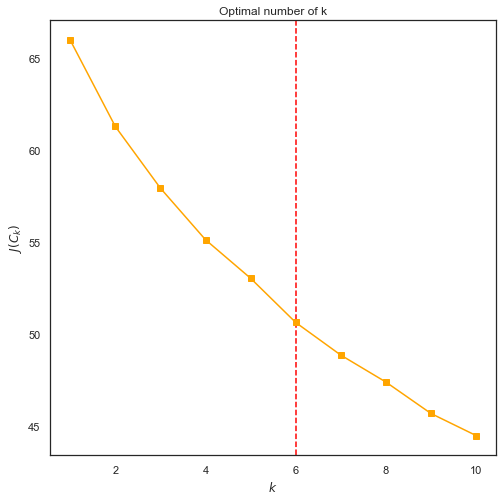

In [187]:
plt.figure(figsize=(8, 8)) 
plt.axvline(x=6, color="red", linestyle='--')
plt.plot(range(1, 11), inertia, marker='s', color="orange");
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');
plt.title('Optimal number of k');

In [188]:
pca = PCA()
pca.fit_transform(X_transform)
exp_var_pca = pca.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

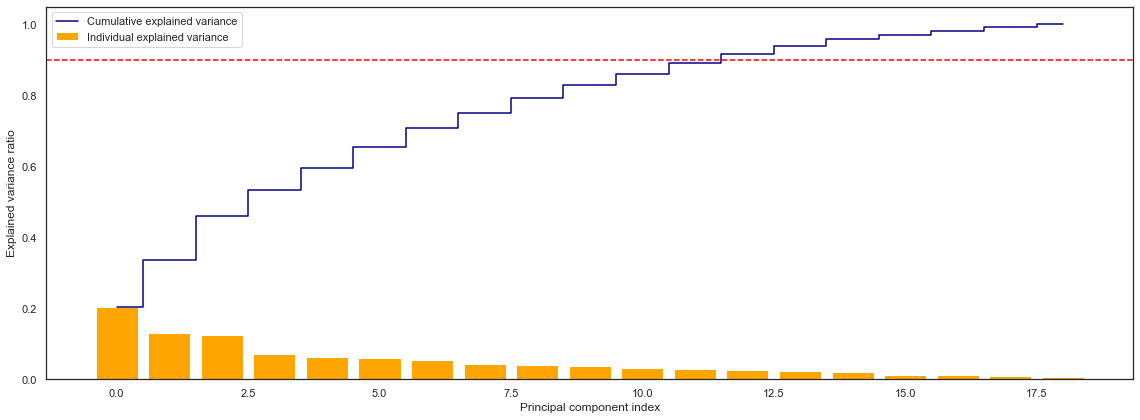

In [189]:
plt.figure(figsize=(16, 6)) 
plt.bar(range(0, len(exp_var_pca)), exp_var_pca, alpha=1,
            align='center', color='orange',
            label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues,
            where='mid', color = 'navy',
            label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.axhline(y=0.9, color="red", linestyle='--')
plt.show()

In [199]:
N_CLUSTERS = 5

In [200]:
#other algorithms and metrics
algorithms = []
algorithms.append(KMeans(n_clusters=N_CLUSTERS, random_state=SEED))
algorithms.append(AffinityPropagation(random_state=SEED))
algorithms.append(SpectralClustering(n_clusters=N_CLUSTERS, random_state=SEED, n_jobs=-1, affinity='nearest_neighbors'))
algorithms.append(AgglomerativeClustering(n_clusters=N_CLUSTERS))
data = []
for algo in tqdm(algorithms):
    algo.fit(X_transform)
    data.append(({
        'Silhouette Score': metrics.silhouette_score(X_transform, algo.labels_, random_state=SEED), 
        'Calinski-Harabasz Score': metrics.calinski_harabasz_score(X_transform, algo.labels_),
        'Davies-Bouldin Score': metrics.davies_bouldin_score(X_transform, algo.labels_)}))

results = pd.DataFrame(data=data, columns=['Silhouette Score', 'Calinski-Harabasz Score', 'Davies-Bouldin Score'],
                       index=['K-means', 'Affinity Propagation', 'Spectral Clustering', 'AgglomerativeClustering'])
# Silhouette Score - The best value is 1 and the worst value is -1.
# higher Calinski-Harabasz score relates to a model with better defined clusters.
# Davies-Bouldin Score: values closer to zero indicate a better partition.
results

100%|██████████| 4/4 [00:00<00:00,  4.91it/s]


,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
K-means,0.182314,30.680512,1.313630
Affinity Propagation,0.093664,19.835229,1.164515
Spectral Clustering,0.061186,18.714853,2.285467
AgglomerativeClustering,0.178616,32.016536,1.352174


In [201]:
final_model = KMeans(n_clusters=N_CLUSTERS, random_state=SEED)
final_model.fit(X_transform)
labels = final_model.labels_

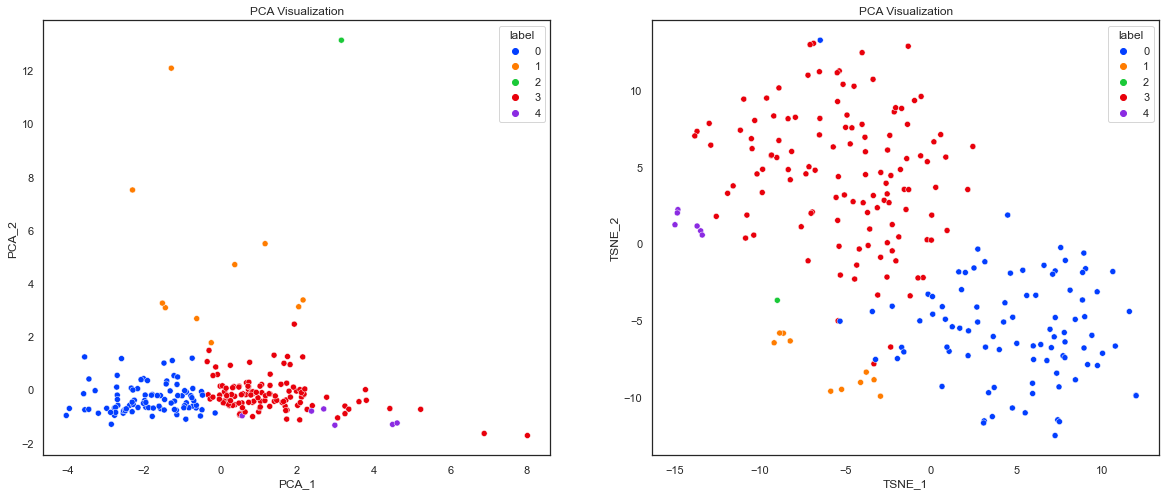

In [202]:
X_pca['label'] = labels
X_pca['country'] = country
X_pca['region'] = region
X_tsne['label'] = labels
X_tsne['country'] = country
X_tsne['region'] = region
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
sns.scatterplot(data=X_pca, x='PCA_1', y='PCA_2', hue='label',
                ax=axes[0], palette='bright').set_title('PCA Visualization');
sns.scatterplot(data=X_tsne, x='TSNE_1', y='TSNE_2', hue='label',
                ax=axes[1], palette='bright').set_title('PCA Visualization');

In [194]:
df['label'] = labels